BSD 3-Clause License

Copyright (c) 2024, Pranjal Choudhury

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir("/content/drive/My Drive/CNN_SR/v3")

# !ls

Mounted at /content/drive
Result_1.png  training_data  unet_sr_model.png	weights


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tifffile
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from skimage.util import random_noise
from skimage.transform import resize
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

## basic functions

In [ ]:
def normalize_image(image):
    """
    Normalize an image to have intensity values between 0 and 1.
    Args:
        image (np.ndarray): Input image.
    Returns:
        np.ndarray: Normalized image with values in the range [0, 1].
    """
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val - min_val == 0:  # Avoid division by zero for constant images
        return np.zeros_like(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image.astype(np.float16)

def preprocess_dataset(dataset):
    """
    Normalize each image in a dataset to [0, 1].
    Args:
        dataset (np.ndarray): Array of shape (N, H, W, C) where N is the number of images.
    Returns:
        np.ndarray: Preprocessed dataset with normalized images.
    """
    return np.array([normalize_image(image) for image in dataset])

## Training data generation

In [ ]:
# Create the training_data directory if it doesn't exist and populate it with training images
os.makedirs('./training_data', exist_ok=True)

# dataframe = pd.read_csv('training_data/artificial_dataset.csv')
images = tifffile.imread('training_data/training_density_4.tif')
nframes, height, width  = images.shape

patches = tifffile.imread('training_data/training_density_4_heatmaps.tif')

In [ ]:
images , patches = preprocess_dataset(images), preprocess_dataset(patches)
images = np.expand_dims(images, axis = -1)
patches = np.expand_dims(patches, axis = -1)

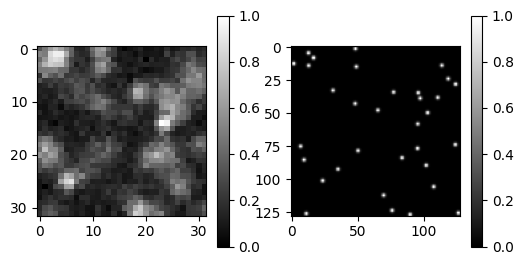

In [ ]:
plt.figure(figsize = (6,3))
plt.subplot(1,2,1)
plt.imshow(images[55], cmap = 'gray')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(patches[55], cmap = 'gray')
plt.colorbar()

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(images, patches, test_size=0.1, random_state=42)
del images, patches

# The unet model 

In [ ]:
def unet_sr(input_shape=(32, 32, 1),  l1_lambda=0.01, l2_lambda=0):
    """
    Optimized U-Net model for super-resolution of widefield images with reduced parameters.

    Args:
        input_shape (tuple): Shape of the input widefield image (H, W, Channels).

    Returns:
        tf.keras.Model: lightweight U-Net model.
    """
    inputs = layers.Input(shape=input_shape, name = 'input')

    #upscaling
    up1 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear', name = 'upscale_1')(inputs)
    up2 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear', name = 'upscale_2')(up1)

    # Encoder
    con1 = layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda), activation='relu', padding='same', name = 'conv_1')(up2)
    con1 = layers.BatchNormalization(name = 'batch_norm_1')(con1)

    con2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name = 'conv_2')(con1)
    con2 = layers.BatchNormalization(name = 'batch_norm_2')(con2)

    con3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name = 'conv_3')(con2)
    con3 = layers.BatchNormalization(name = 'batch_norm_3')(con3)

    # Bottleneck
    con4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name = 'conv_4')(con3)
    con4 = layers.BatchNormalization(name = 'batch_norm_4')(con4)

    # Decoder
    add1 = layers.concatenate([con4, con3], name = 'add_1')

    con5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name = 'conv_5')(add1)
    con5 = layers.BatchNormalization(name = 'batch_norm_5')(con5)

    add2 = layers.concatenate([con5, con2], name = 'add_2')
    con6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name = 'conv_6')(add2)
    con6 = layers.BatchNormalization(name = 'batch_norm_6')(con6)

    add3 = layers.concatenate([con6, con1] , name = 'add_3')

    con7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'conv_7')(add3)
    con7 = layers.BatchNormalization(name = 'batch_norm_7')(con7)

    con8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_8')(con7)
 
    outputs = layers.Conv2D(1, (1, 1), activation='relu', name='output')(con8)

    model = Model(inputs, outputs)

    return model


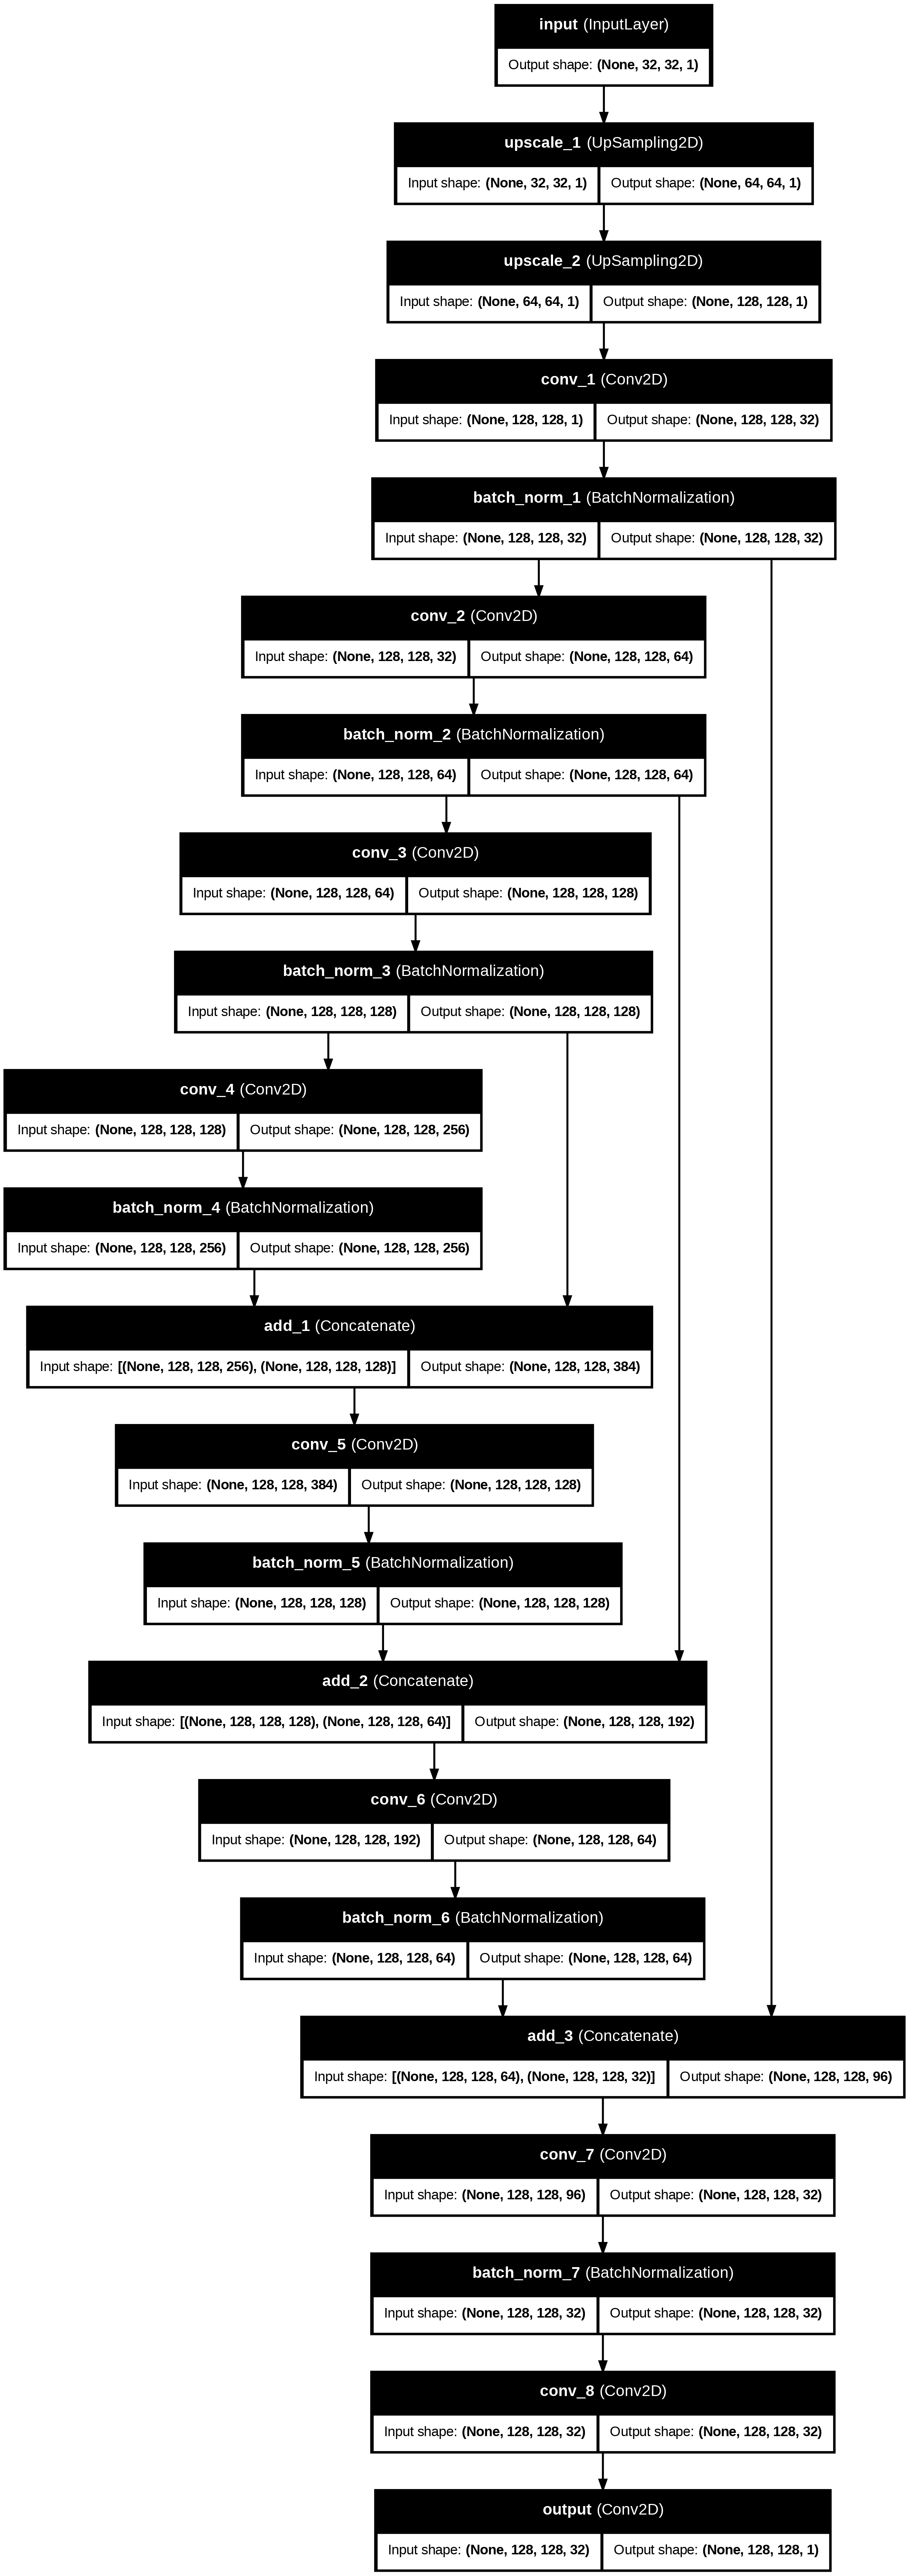

In [ ]:

from tensorflow.keras.utils import plot_model

# Assuming 'unet_sr' is defined as in your provided code
model = unet_sr()

# Plot the model
plot_model(model, to_file='unet_sr_model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False)

In [ ]:
def create_psf(kernel_size=11, sigma=2):
    """
    Generate a Gaussian PSF kernel.
    Args:
        kernel_size (int): Size of the PSF kernel.
        sigma (float): Standard deviation of the Gaussian PSF.
    Returns:
        tf.Tensor: PSF kernel.
    """
    x = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    y = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    x, y = np.meshgrid(x, y)
    psf = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    psf /= np.sum(psf)  # Normalize the PSF
    return tf.constant(psf, dtype=tf.float32)


psf_kernel = create_psf(kernel_size=21, sigma=1.5)


def custom_loss(psf_kernel):
    """
    Custom loss function combining MSE and PSF-based regularization.
    Args:
        psf_kernel (tf.Tensor): PSF kernel for regularization.
    Returns:
        Function: Loss function for model training.
    """
    psf_kernel = psf_kernel[..., tf.newaxis, tf.newaxis]

    def loss(y_true, y_pred):
        # Standard MSE loss
        # mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Mean Absolute Error (MAE) loss
        # mae_loss = tf.reduce_mean(tf.abs(y_true - y_pred))

        # SSIM loss
        # ssim_loss = tf.image.ssim(y_true, y_pred, max_val=1.0)

        # PSF Convolution Regularization
        y_pred_blurred = tf.nn.conv2d(
            y_pred, psf_kernel, strides=[1, 1, 1, 1], padding='SAME'
        )
        psf_loss = tf.reduce_mean(tf.square(y_pred_blurred - y_true))

        # Weighted combination
        # total_loss = 0.294 * mse_loss + 0.05 * mae_loss + 0.7 * psf_loss + 0.01 * ssim_loss
        total_loss = psf_loss
        return total_loss
    return loss

In [ ]:
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Define the ModelCheckpoint callback for saving the best weights
best_checkpoint_filepath = './weights/best.weights.h5'
best_model_checkpoint_callback = ModelCheckpoint(
    filepath=best_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,  # Save only the best weights
    save_freq='epoch'
)

# Create the weights directory if it doesn't exist
os.makedirs('./weights', exist_ok=True)

In [ ]:
model = unet_sr(input_shape=x_train.shape[1:])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ upscale_1 (UpSampling2D)  │ (None, 64, 64, 1)      │              0 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ upscale_2 (UpSampling2D)  │ (None, 128, 128, 1)    │              0 │ upscale_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_1 (Conv2D)           │ (None, 128, 128, 32)   │            320 │ upscale_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_norm_1              │ (None, 128, 128, 32)   │            128 │ conv_1[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_2 (Conv2D)           │ (None, 128, 128, 64)   │         18,496 │ batch_norm_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_norm_2              │ (None, 128, 128, 64)   │            256 │ conv_2[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_3 (Conv2D)           │ (None, 128, 128, 128)  │         73,856 │ batch_norm_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_norm_3              │ (None, 128, 128, 128)  │            512 │ conv_3[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_4 (Conv2D)           │ (None, 128, 128, 256)  │        295,168 │ batch_norm_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_norm_4              │ (None, 128, 128, 256)  │          1,024 │ conv_4[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Concatenate)       │ (None, 128, 128, 384)  │              0 │ batch_norm_4[0][0],    │
│                           │                        │                │ batch_norm_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_5 (Conv2D)           │ (None, 128, 128, 128)  │        442,496 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_norm_5              │ (None, 128, 128, 128)  │            512 │ conv_5[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Concatenate)       │ (None, 128, 128, 192)  │              0 │ batch_norm_5[0][0],    │
│                           │                        │                │ batch_norm_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_6 (Conv2D)           │ (None, 128, 128, 64)   │        110,656 │ add_2[0][0]            │
├──────────────────────

 Total params: 980,769 (3.74 MB)

 Trainable params: 979,361 (3.74 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# Compile the model with the custom loss
model.compile(optimizer=optimizer, loss=custom_loss(psf_kernel), metrics=['mae', 'acc'])
# model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'acc'])

In [ ]:
# Train the model with the callbacks
history = model.fit(
    x_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[reduce_lr,  best_model_checkpoint_callback]
)


Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 245s 663ms/step - acc: 0.7498 - loss: 0.2068 - mae: 0.0633 - val_acc: 0.7733 - val_loss: 0.0489 - val_mae: 0.0132 - learning_rate: 0.0010
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 168s 518ms/step - acc: 0.7741 - loss: 0.0389 - mae: 0.0163 - val_acc: 0.7733 - val_loss: 0.0212 - val_mae: 0.0153 - learning_rate: 0.0010
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 202s 520ms/step - acc: 0.7738 - loss: 0.0164 - mae: 0.0165 - val_acc: 0.7731 - val_loss: 0.0140 - val_mae: 0.0426 - learning_rate: 0.0010
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 202s 521ms/step - acc: 0.7738 - loss: 0.0072 - mae: 0.0169 - val_acc: 0.7733 - val_loss: 0.0070 - val_mae: 0.0138 - learning_rate: 0.0010
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 146s 519ms/step - acc: 0.7733 - loss: 0.0059 - mae: 0.0157 - val_acc: 0.7733 - val_loss: 0.0058 - val_mae: 0.0181 - learning_rate: 0.0010


In [ ]:
# model.save('CNN_SR.keras')

In [ ]:
model.save_weights('./weights/final.weights.h5')

In [ ]:


def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training & validation loss values
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title('Model Loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper right')
    axes[0].grid(True, linestyle='--', alpha=0.5) # Add a grid

    # Plot training & validation accuracy values (if available)
    if 'acc' in history.history:
        axes[1].plot(history.history['acc'])
        axes[1].plot(history.history['val_acc'])
        axes[1].set_title('Model Accuracy')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['Train', 'Validation'], loc='upper left')
        axes[1].grid(True, linestyle='--', alpha=0.5) # Add a grid
    else:
        axes[1].set_title('Model Accuracy (Not Available)')

    plt.tight_layout()
    plt.show()


# plot_training_history(history)

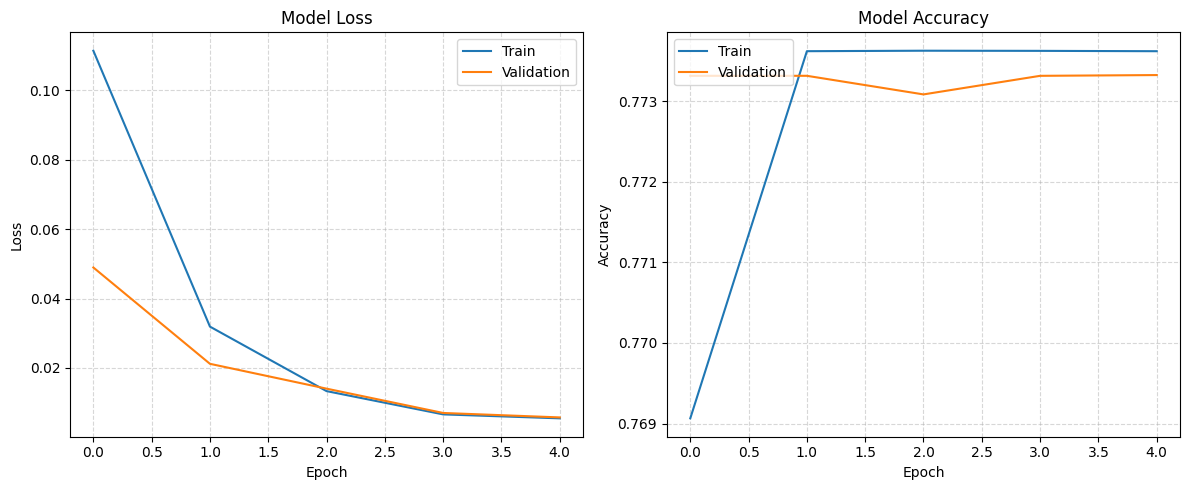

In [ ]:
plot_training_history(history)


In [ ]:

history_df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
history_df.to_csv('training_data/training_history.csv', index=False)

# use a trained model

## test on validation data (x_val and y_val)

In [ ]:
model = unet_sr(input_shape=x_train.shape[1:])
model.load_weights('./weights/best.weights.h5')

NameError: name 'x_train' is not defined

In [ ]:
widefield_image, super_resolved_image = preprocess_dataset(x_val), preprocess_dataset(y_val)
widefield_image.shape

(1000, 32, 32, 1)

In [ ]:
# ppp = model.predict(x_val)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step


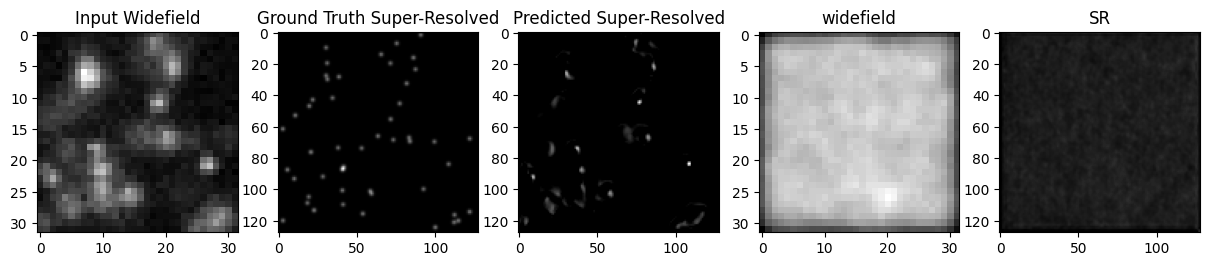

In [ ]:


sample_idx = 100

predicted_sr = model.predict(widefield_image)

# Plot results
plt.figure(figsize=(15, 3))
plt.subplot(1, 5, 1)
plt.title("Input Widefield")
plt.imshow(widefield_image.squeeze()[sample_idx], cmap='gray')
plt.subplot(1, 5, 2)
plt.title("Ground Truth Super-Resolved")
plt.imshow(super_resolved_image.squeeze()[sample_idx], cmap='gray')
plt.subplot(1, 5, 3)
plt.title("Predicted Super-Resolved")
plt.imshow(predicted_sr.squeeze()[sample_idx], cmap='gray')
plt.subplot(1, 5, 4)
plt.title("widefield")
plt.imshow(np.sum(widefield_image, axis = 0), cmap='gray')
plt.subplot(1, 5, 5)
plt.title("SR")
plt.imshow(np.sum(predicted_sr.squeeze(), axis = 0), cmap='gray')
plt.show()

# application on experimental images

In [ ]:
import tifffile

In [ ]:
test = tifffile.imread('../sequence-as-stack-MT0.N1.HD-2D-Exp.tif')
# test = resize(test, (test.shape[0],64,64))

In [ ]:
widefield_image_stack = preprocess_dataset(test)
widefield_image_stack = np.expand_dims(widefield_image_stack, axis = -1)

In [ ]:
model_p = unet_sr(input_shape=widefield_image_stack.shape[1:])
model_p.load_weights('./weights/final.weights.h5')

In [ ]:
predicted_sr = model_p.predict(widefield_image_stack)

79/79 ━━━━━━━━━━━━━━━━━━━━ 109s 751ms/step


In [ ]:
processed = np.where(predicted_sr < 0.1, 0, predicted_sr)

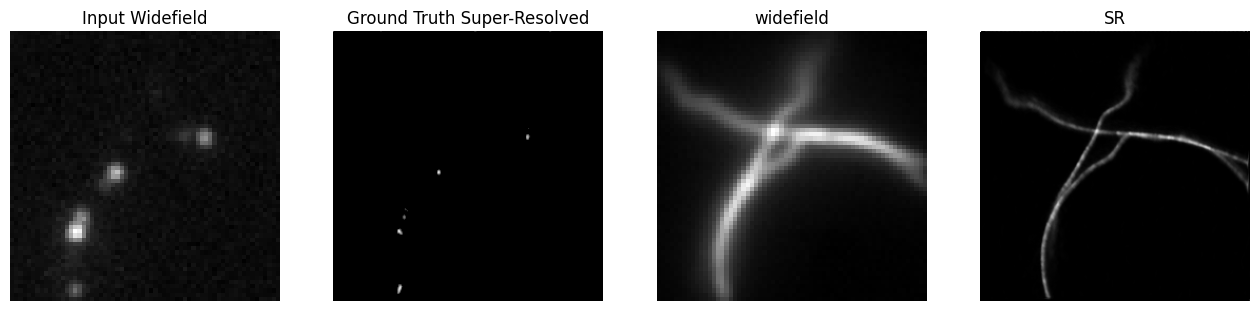

In [ ]:
sample_idx = 10

# predicted_sr = model.predict(widefield_image_stack)

# Plot results
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.title("Input Widefield")
plt.imshow(widefield_image_stack.squeeze()[sample_idx], cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.title("Ground Truth Super-Resolved")
plt.imshow(processed[sample_idx], cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.title("widefield")
plt.imshow(np.sum(widefield_image_stack, axis = 0), cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.title("SR")
plt.imshow(np.sum(processed.squeeze(), axis = 0), vmax = 100, cmap='gray')
plt.axis('off')
plt.savefig('Result_1.png', dpi = 300)
plt.show()

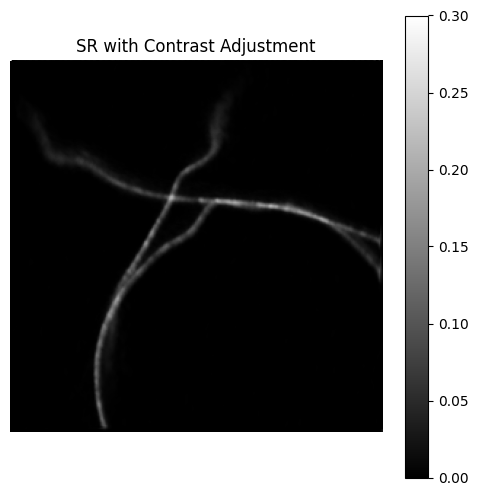

In [ ]:

processed = np.where(predicted_sr < 0.1, 0, predicted_sr)
image_sum = np.sum(processed.squeeze(), axis=0)

# Normalize the image to the range [0, 1] for better visualization
# Avoid division by zero if the image is all zeros
if np.max(image_sum) - np.min(image_sum) != 0:
    normalized_image_sum = (image_sum - np.min(image_sum)) / (np.max(image_sum) - np.min(image_sum))
else:
    normalized_image_sum = image_sum

# Adjust vmin and vmax for better contrast
plt.figure(figsize=(6, 6))  # Adjust figure size if needed
plt.imshow(normalized_image_sum, cmap='gray', vmin=0, vmax=0.3) # Adjust vmax as needed
plt.colorbar()
plt.title("SR with Contrast Adjustment")
plt.axis('off')
plt.show()

tifffile.imwrite('predicted_sr_tubulin.tif', normalized_image_sum)
tifffile.imwrite('widefield_tubulin.tif', np.sum(widefield_image_stack, axis = 0))

# save the predicted image

In [ ]:
tifffile.imwrite('predicted_sr_tubulin.tif', np.squeeze(predicted_sr))